In [8]:
import cv2
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tqdm import tqdm
from keras.preprocessing import image

In [2]:
def build_model(pretrained):
    model = Sequential([
        pretrained,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy']
    )
    
    return model

In [4]:
base_path = 'C:\\Users\\eesha\\OneDrive\\Desktop\\Mooncraft\\Cfake'   #set the path to the location of the Cfake folder
image_gen = ImageDataGenerator(rescale=1./255.,
                               rotation_range=20,
                               #shear_range=0.2,
                               #zoom_range=0.2,
                               horizontal_flip=True)

train_flow = image_gen.flow_from_directory(
    base_path,
    target_size=(32, 32),
    batch_size=64,
    class_mode='binary'
)

Found 99688 images belonging to 2 classes.


In [5]:
image_gen1 = ImageDataGenerator(rescale=1./255.)

valid_flow = image_gen1.flow_from_directory(
    'C:\\Users\\eesha\\OneDrive\\Desktop\\Mooncraft\\train',  #set the location to the path of the testing folder 
    target_size=(32, 32),
    batch_size=64,
    class_mode='binary'
)

Found 216 images belonging to 2 classes.


In [6]:
densenet = DenseNet121(
    weights=None,
    include_top=False,
    input_shape=(32,32,3)
)
model = build_model(densenet)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1, 1, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 7038529 (26.85 MB)
Trainable params: 6954881 (26.53 MB)
Non-trainable params: 83648 (326.75 KB)
_________________________________________________________________


In [7]:
train_steps = 99688//64
valid_steps = 216//64

history = model.fit(
    train_flow,
    epochs = 5,
    steps_per_epoch= train_steps,
    validation_data= valid_flow,
    validation_steps= valid_steps
)

Epoch 1/5
1557/1557 [==============================] - 1499s 943ms/step - loss: 0.3251 - accuracy: 0.8582 - val_loss: 0.6004 - val_accuracy: 0.7760
Epoch 2/5
1557/1557 [==============================] - 818s 526ms/step - loss: 0.2401 - accuracy: 0.9019 - val_loss: 1.1759 - val_accuracy: 0.5833
Epoch 3/5
1557/1557 [==============================] - 859s 552ms/step - loss: 0.2229 - accuracy: 0.9095 - val_loss: 0.1926 - val_accuracy: 0.9115
Epoch 4/5
1557/1557 [==============================] - 861s 553ms/step - loss: 0.1850 - accuracy: 0.9263 - val_loss: 0.6340 - val_accuracy: 0.7708
Epoch 5/5
1557/1557 [==============================] - 851s 546ms/step - loss: 0.1708 - accuracy: 0.9322 - val_loss: 0.4147 - val_accuracy: 0.8281


In [10]:
save_path='C:\\Users\\eesha\\OneDrive\\Desktop\\Mooncraft\\'   #set the path to the directory where you want to save your trained model
model_name='trained_model.keras'  #name of the model
fpath=save_path+model_name
model.save(fpath)

In [11]:
train_flow.class_indices

{'FAKE': 0, 'REAL': 1}

In [12]:
def ImagePrediction(loc):
    loca=loc.replace('\\', '\\\\')
    test_image = image.load_img(loca, target_size = (32,32))
    plt.axis('off')
    plt.imshow(test_image)
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis =0)
    result = model.predict(test_image)
    if result[0][0] == 1:
        predictions = 'Real'
    else:
        predictions = 'Fake'
    print('Prediction: ',predictions)

Enter Location of Image to predict: C:\Users\eesha\OneDrive\Desktop\Mooncraft\valid\fake\1018 (6).jpg
1/1 [==============================] - 2s 2s/step
Prediction:  Real


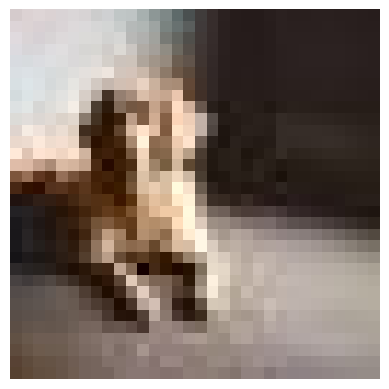

In [13]:
img = input("Enter Location of Image to predict: ")  # enter the path of the image you want to detect (take images from the valid folder)
test_image_1 = ImagePrediction(img)

In [14]:
test_flow = image_gen1.flow_from_directory(
    'C:\\Users\\eesha\\OneDrive\\Desktop\\Mooncraft\\valid',
    target_size=(32, 32),
    batch_size=1,
    shuffle = False,
    class_mode='binary'
)
y_pred=model.predict(test_flow)
y_test = test_flow.classes

Found 96 images belonging to 2 classes.
96/96 [==============================] - 3s 12ms/step


In [15]:
print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))
print()
print(metrics.classification_report(y_test, y_pred > 0.5))

ROC AUC Score: 0.98828125
AP Score: 0.988404575142804

              precision    recall  f1-score   support

           0       0.78      0.98      0.87        48
           1       0.97      0.73      0.83        48

    accuracy                           0.85        96
   macro avg       0.88      0.85      0.85        96
weighted avg       0.88      0.85      0.85        96

